In [160]:
import   numpy                   as       np
from     scipy                   import   stats
import   pandas                  as       pd
import   seaborn                 as       sns
import   matplotlib.pyplot       as       plt
from     matplotlib.colors       import   ListedColormap
from     sklearn.ensemble        import   RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from     sklearn.linear_model    import   LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from     sklearn.svm             import   SVC, LinearSVC
from     sklearn.metrics         import   f1_score, confusion_matrix
from     sklearn.metrics         import   classification_report, roc_curve, auc
from     sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from     sklearn.model_selection  import   RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from     xgboost                 import   XGBClassifier, plot_importance
from     sklearn.preprocessing   import   StandardScaler
from    sklearn.decomposition    import   PCA
import   warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# np.random.seed(43)

## Data links

In [161]:
# git_base_data_url = "https://raw.githubusercontent.com/ngnawejonas/data_contest_kernel_methods/master/data/"
git_base_data_url = "../data/"
url_xtrain = git_base_data_url + "xtrain.txt"
url_ytrain = git_base_data_url + "ytrain.txt"
url_xtest = git_base_data_url + "xtest.txt"

## Loading the data

In [162]:
x_ = pd.read_csv(url_xtrain, index_col = 0,  sep='\t', header = None)
xtrainfull = x_.T
ytrainfull = pd.read_csv(url_ytrain, header = None)
xtestprof  = pd.read_csv(url_xtest, index_col = 0,  sep='\t', header = None)
xtestprof = xtestprof.T

In [163]:
(xtrainfull.max() - xtrainfull.min()).max()

13.26

## Some Data Preparation

In [164]:
## Normalize the data
scaler = StandardScaler().fit(xtrainfull)

In [165]:
Xtrain, Xtest, ytrain, ytest = 0,0,0,0
norm_xtrain = scaler.transform(xtrainfull)
# norm_xtrain = xtrainfull
xtestprof = scaler.transform(xtestprof)
def reset_features(percentage=0.3):
    return train_test_split(np.array(norm_xtrain), np.array(ytrainfull), test_size = percentage)

In [166]:
Xtrain, Xtest, ytrain, ytest =  reset_features()

#### feature selection function

In [167]:
def select_features(model,Xtrain, ytrain, select_method='default', percentage=0.2):
    select = SelectFromModel(model)
    if select_method == 'rfecv':
        select = RFECV(model,n_jobs=-1)
    select.fit(Xtrain, ytrain)
    return select

### Some Visualization of the Data

In [168]:
# xtrain.describe()

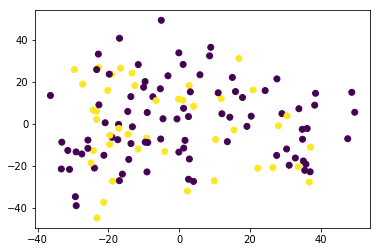

In [169]:
pca = PCA(n_components = 2)
rxtrain = pca.fit_transform(Xtrain)
plt.scatter(rxtrain[:,0], rxtrain[:,1], c=ytrain.ravel());

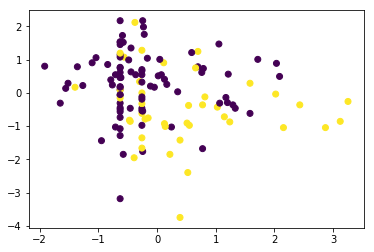

In [170]:
rxtrain = SelectKBest(k=2).fit_transform(Xtrain, ytrain)
plt.scatter(rxtrain[:,0], rxtrain[:,1], c=ytrain.ravel());

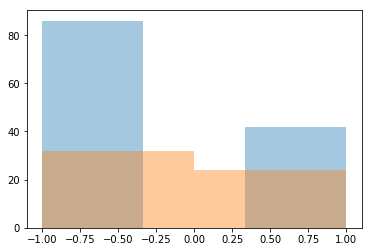

In [171]:
# N, D = Xtrain.shape
# Ntest, _ = Xtest.shape
# print(N,Ntest,D)
#plt.plot(ytrain);
#plt.hist(ytrain);
#sns.distplot(Ytrain);
sns.distplot(ytrain,kde=False);
sns.distplot(ytest,kde=False);

## Models Training

In [172]:
def run_model(model, algname, X, y, Xtest, ytest):
    # build the model on training data
    model.fit(X, y)
    
    # make predictions for training data
    ypred_train = model.predict(X).reshape((-1,1))
    
    ypred_test = model.predict(Xtest).reshape((-1,1))
    
    
    print('--------------------------')
    print(algname, "Training accuracy: ", 100* model.score(X, y))
    print('--------------------------')
    print(algname, "Testing accuracy: ", 100* model.score(Xtest, ytest))
    print('--------------------------')
    print('Confusion Matrix')
    sns.heatmap(confusion_matrix(ytest, ypred_test), annot=True, linewidths=.5, square = True, cmap = "YlGnBu")
    print('--------------------------')
    
    # Compute ROC curve and ROC area for each class
    try:
        y_score = model.decision_function(Xtest)
    except AttributeError:
        y_score = model.predict_proba(Xtest)[:,1]
        
    fpr, tpr, _ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic- ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
def train_report(model,algname, CV_model, Xtrain, ytrain, Xtest, ytest):
    print("Before hyperparameter tuning: ")
    run_model(model, algname, Xtrain, ytrain, Xtest, ytest)
    print(" ")

    print("After hyperparameter tuning cv = 5: ")
    print("Random search optimal values")
    run_model(CV_model.best_estimator_, algname, Xtrain, ytrain, Xtest, ytest)
    
def prediction_to_file(model,xt, file='abigail_ines_jonas.txt'):
    try:
        prediction = model.decision_function(xt)
    except AttributeError:
        prediction = model.predict_proba(Xtest)[:,1]
    # pd.DataFrame(prediction).to_csv("abigail_ines_jonas.txt", delimiter=',')
    np.savetxt(file,prediction, delimiter=',')

## Hyperparameter tuning and cross validation

## Kernel Methods
*Logistic Regression, Ridge Classifier, SVM*

### Logistic Regression

In [269]:
lr_model = LogisticRegression()

In [270]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(lr_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [271]:
params = {
        "C" : 10**np.linspace(-1, 2, 100),
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

lrCV_model1 = RandomizedSearchCV(lr_model, params, cv = 5,n_jobs=-1)
lrCV_model1.fit(Xtrain, ytrain.ravel())
print("Random Search results: ", lrCV_model1.best_params_)

Random Search results:  {'solver': 'lbfgs', 'C': 26.560877829466868}


Before hyperparameter tuning: 
--------------------------
Logistic Regression Training accuracy:  100.0
--------------------------
Logistic Regression Testing accuracy:  58.92857142857143
--------------------------
Confusion Matrix
--------------------------


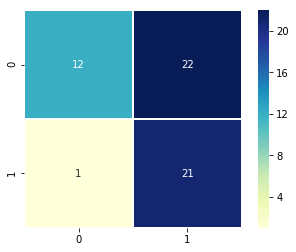

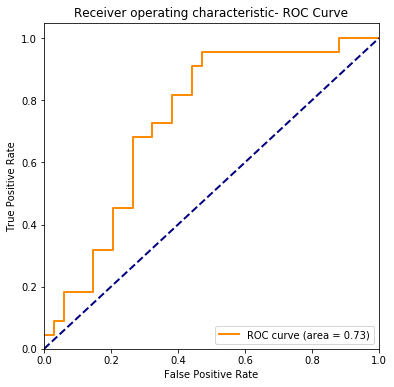

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
Logistic Regression Training accuracy:  100.0
--------------------------
Logistic Regression Testing accuracy:  66.07142857142857
--------------------------
Confusion Matrix
--------------------------


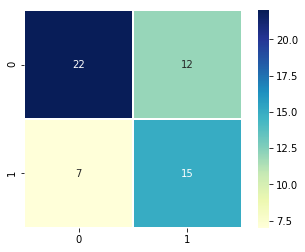

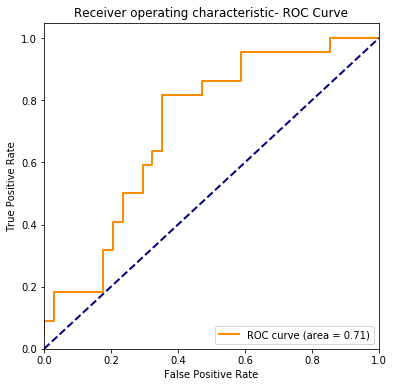

In [274]:
train_report(lr_model, "Logistic Regression", lrCV_model1, Xtrain, ytrain, Xtest, ytest)

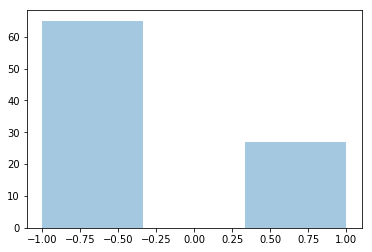

In [277]:
sns.distplot(lrCV_model1.best_estimator_.predict(select.transform(xtestprof)),kde=False);

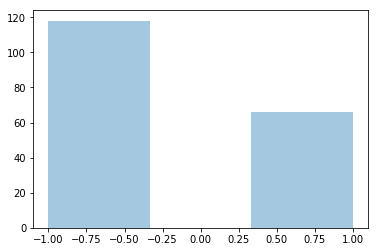

In [281]:
sns.distplot(ytrainfull,kde=False);

In [283]:
prediction_to_file(lrCV_model1.best_estimator_,select.transform(xtestprof), file="abigail_ines_jonasLog_F.txt")

### Ridge Classifier

In [264]:
rrc_model = RidgeClassifier()

In [265]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(rrc_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [266]:
params = {
        "alpha" : np.array(range(1, 101))/100,
        "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']}

rccCV_model1 = RandomizedSearchCV(rrc_model, params, cv = 5)
rccCV_model1.fit(Xtrain, ytrain.ravel())
optimal_params_rrc = rccCV_model1.best_params_
print("Random Search results: ", optimal_params_rrc)
algname = "Ridge Classifier"

Random Search results:  {'solver': 'auto', 'alpha': 0.84}


Before hyperparameter tuning: 
--------------------------
Ridge Classifier Training accuracy:  100.0
--------------------------
Ridge Classifier Testing accuracy:  57.14285714285714
--------------------------
Confusion Matrix
--------------------------


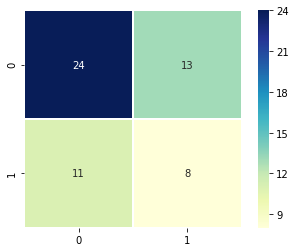

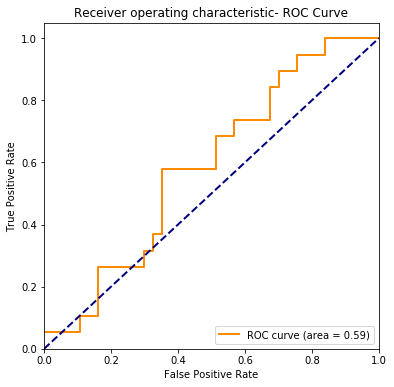

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
Ridge Classifier Training accuracy:  100.0
--------------------------
Ridge Classifier Testing accuracy:  57.14285714285714
--------------------------
Confusion Matrix
--------------------------


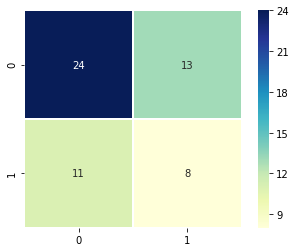

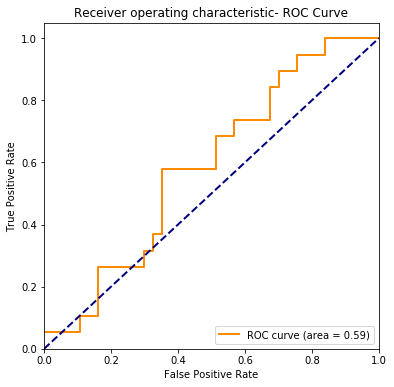

In [267]:
train_report(rrc_model, algname,rccCV_model1, Xtrain, ytrain, Xtest, ytest)

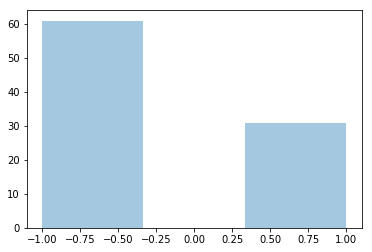

In [268]:
# prediction_to_file(rrc_model,select.transform(xtestprof))
sns.distplot(rccCV_model1.best_estimator_.predict(select.transform(xtestprof)),kde=False);

### SVM

In [245]:
svm_model = SVC()

In [246]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(rrc_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [247]:
params = {
        "C" : 10**np.linspace(-1,2,100),
        "kernel" : ['linear', 'poly', 'rbf', 'sigmoid', 'rbf' ],
        "gamma": ['auto', 0.001, 0.01, 0.1, 1, 10, 100]}

svmCV_model1 = RandomizedSearchCV(svm_model, params, cv = 5)
svmCV_model1.fit(Xtrain, ytrain.ravel())
optimal_params_svm = svmCV_model1.best_params_
print("Random Search results: ", optimal_params_svm)
algname = "SVM"

Random Search results:  {'kernel': 'linear', 'gamma': 0.001, 'C': 20.09233002565048}


Before hyperparameter tuning: 
--------------------------
SVM Training accuracy:  100.0
--------------------------
SVM Testing accuracy:  64.28571428571429
--------------------------
Confusion Matrix
--------------------------


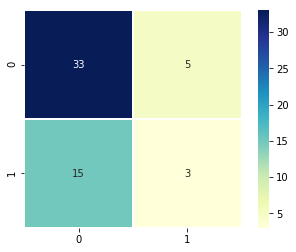

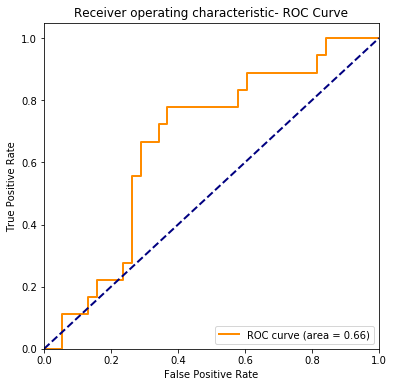

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
SVM Training accuracy:  100.0
--------------------------
SVM Testing accuracy:  57.14285714285714
--------------------------
Confusion Matrix
--------------------------


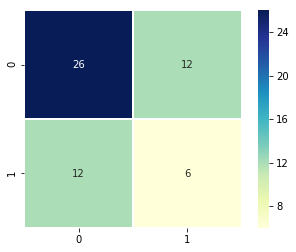

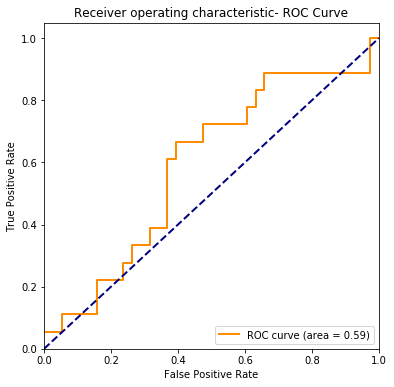

In [248]:
train_report(svm_model, algname, svmCV_model1, Xtrain, ytrain, Xtest, ytest)

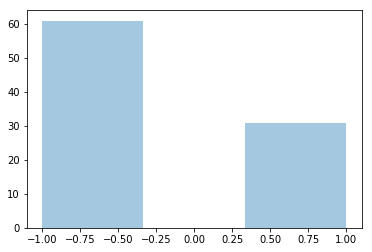

In [249]:
sns.distplot(svmCV_model1.best_estimator_.predict(select.transform(xtestprof)),kde=False);

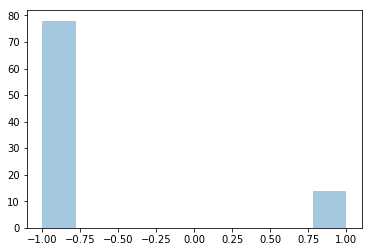

In [250]:
sns.distplot(svm_model.predict(select.transform(xtestprof)),kde=False);

## Ensemble Methods
  *Random Forest, XGBClassifier, Gradient Tree Boosting, Extra Trees, AdaBoost*

### Random Forest

In [234]:
rf_model = RandomForestClassifier(n_jobs = -1, oob_score= True)

In [235]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(rf_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [236]:
params = {
        'max_depth': np.array(range(50,1000)),
         'max_features': ['auto', 'sqrt', 'log2'],
         'min_samples_leaf': np.array(range(1,10)),
         'min_samples_split': 0.1 * np.array(range(1,10)),
         'n_estimators': np.array(range(20,1000))}

rfCV_model = RandomizedSearchCV(rf_model, params, cv = 5,n_jobs=-1)
rfCV_model.fit(Xtrain, ytrain.ravel())
optimal_params = rfCV_model.best_params_
print("Search results: ", optimal_params)

Search results:  {'n_estimators': 228, 'min_samples_split': 0.4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 763}


Before hyperparameter tuning: 
--------------------------
Random Forest Training accuracy:  98.4375
--------------------------
Random Forest Testing accuracy:  69.64285714285714
--------------------------
Confusion Matrix
--------------------------


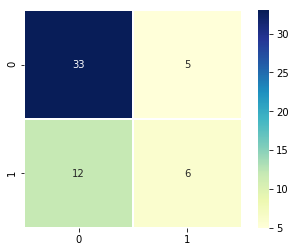

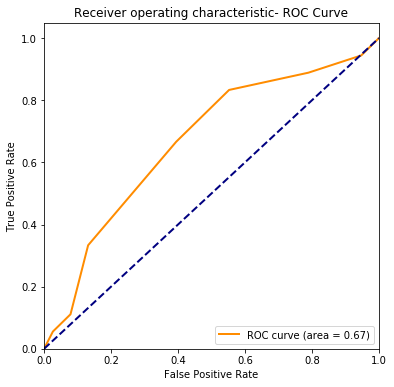

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
Random Forest Training accuracy:  85.9375
--------------------------
Random Forest Testing accuracy:  69.64285714285714
--------------------------
Confusion Matrix
--------------------------


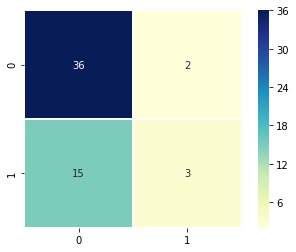

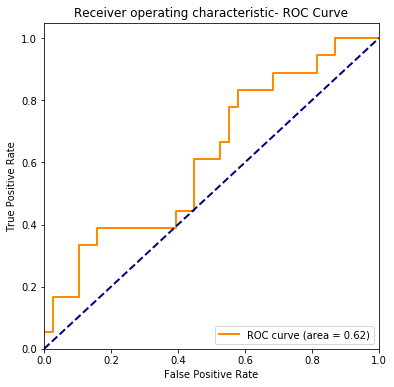

In [237]:
train_report(rf_model,"Random Forest", rfCV_model, Xtrain, ytrain, Xtest, ytest)

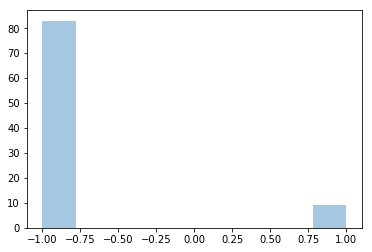

In [238]:
sns.distplot(rfCV_model.best_estimator_.predict(select.transform(xtestprof)),kde=False);

### XGBClassifier

In [227]:
# sns.distplot(rf_model.predict(xtestprof),kde=False);
xgbmodel = XGBClassifier()

In [228]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(xgbmodel, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [229]:
params = {
        'max_depth': np.array(range(10,300)),
         'learning_rate': [0.5, 0.1, 0.01, 0.001],
         'n_estimators': np.array(range(50,1000))}

xgbCV_model = RandomizedSearchCV(xgbmodel, params, cv = 5,n_jobs=-1)
xgbCV_model.fit(Xtrain, ytrain.ravel())
optimal_params = xgbCV_model.best_params_
print("Search results: ", optimal_params)

Search results:  {'n_estimators': 286, 'max_depth': 168, 'learning_rate': 0.5}


Before hyperparameter tuning: 
--------------------------
XGBClassifier Training accuracy:  100.0
--------------------------
XGBClassifier Testing accuracy:  64.28571428571429
--------------------------
Confusion Matrix
--------------------------


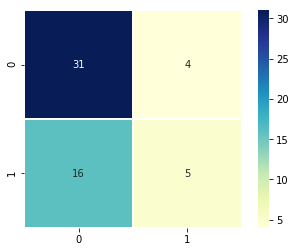

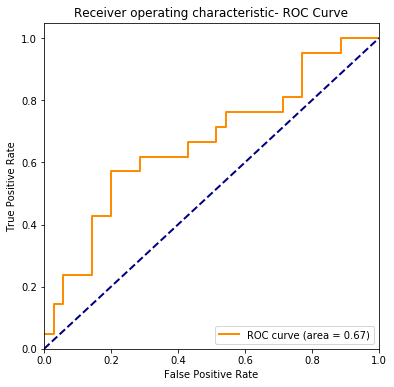

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
XGBClassifier Training accuracy:  100.0
--------------------------
XGBClassifier Testing accuracy:  58.92857142857143
--------------------------
Confusion Matrix
--------------------------


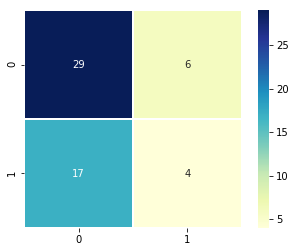

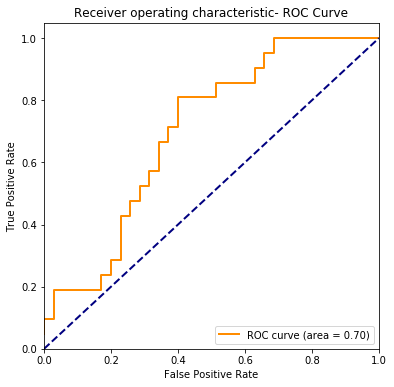

In [230]:
train_report(xgbmodel, "XGBClassifier", xgbCV_model, Xtrain, ytrain, Xtest, ytest)

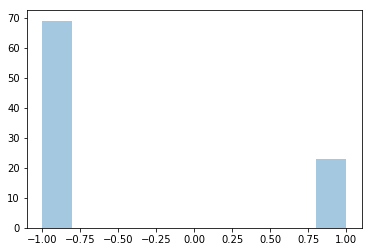

In [233]:
# prediction_to_file(xgbCV_model.best_estimator_,select.transform(xtestprof), file="abigail_ines_jonas-xgb7570.txt")
sns.distplot(xgbCV_model.best_estimator_.predict(select.transform(xtestprof)),kde=False);

### Gradient Boosting

In [232]:
gb_model = GradientBoostingClassifier()

In [176]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(gb_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [177]:
Xtrain.shape

(128, 280)

In [213]:
params = {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.5, 0.1, 0.01, 0.001],
        'criterion': ['friedman_mse', 'mse', 'mae']}

gbCV_model1 = RandomizedSearchCV(gb_model, params, cv = 5,n_jobs=-1)
gbCV_model1.fit(Xtrain, ytrain.ravel())
optimal_params_gb = gbCV_model1.best_params_
print("Random Search results: ", optimal_params_gb)

KeyboardInterrupt: 

In [ ]:
train_report(gb_model,"Gradient Boosting", gbCV_model1, Xtrain, ytrain, Xtest, ytest)

### Extra Trees Classifier

In [199]:
xtmodel = ExtraTreesClassifier()

In [208]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(xtmodel, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [209]:
params = {
        'max_depth': np.array(range(100,1000)),
         'max_features': ['auto', 'sqrt', 'log2'],
         'min_samples_leaf': np.array(range(1,10)),
         'min_samples_split': 0.1 * np.array(range(1,10)),
         'n_estimators': np.array(range(100,1000))}

xtCV_model = RandomizedSearchCV(xtmodel, params, cv = 5, n_jobs = -1)
xtCV_model.fit(Xtrain, ytrain.ravel())
optimal_params = xtCV_model.best_params_
print("Search results: ", optimal_params)

Search results:  {'n_estimators': 132, 'min_samples_split': 0.30000000000000004, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 463}


Before hyperparameter tuning: 
--------------------------
Extra Trees Training accuracy:  100.0
--------------------------
Extra Trees Testing accuracy:  60.71428571428571
--------------------------
Confusion Matrix
--------------------------


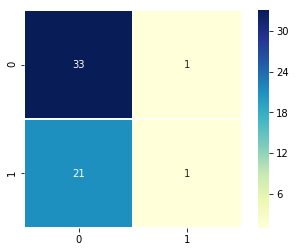

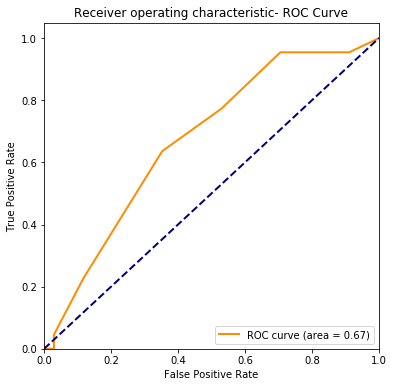

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
Extra Trees Training accuracy:  79.6875
--------------------------
Extra Trees Testing accuracy:  60.71428571428571
--------------------------
Confusion Matrix
--------------------------


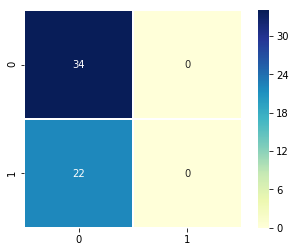

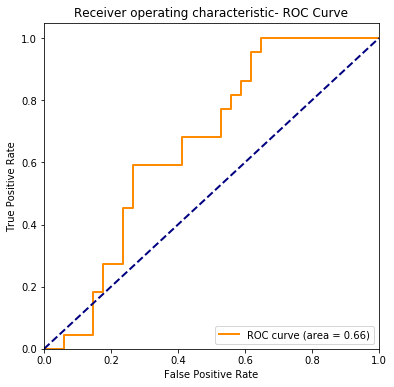

In [210]:
train_report(xtmodel,"Extra Trees", xtCV_model, Xtrain, ytrain, Xtest, ytest)

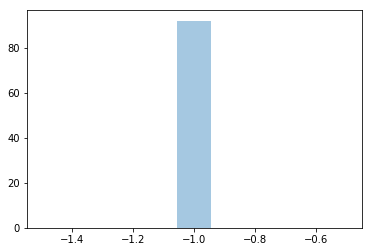

In [211]:
prediction_to_file(xtCV_model.best_estimator_,select.transform(xtestprof))
sns.distplot(xtCV_model.best_estimator_.predict(select.transform(xtestprof)),kde=False);

### AdaBoost

In [221]:
adb_model =   AdaBoostClassifier()

In [222]:
Xtrain, Xtest, ytrain, ytest = reset_features()
select = select_features(adb_model, Xtrain, ytrain)
Xtrain = select.transform(Xtrain)
Xtest = select.transform(Xtest)

In [223]:
params = {
        'max_depth': np.array(range(50,300)),
         'learning_rate': [1., 0.5, 0.1, 0.01, 0.001],
         'n_estimators': np.array(range(100,1000))}

adbCV_model = RandomizedSearchCV(xgbmodel, params, cv = 5)
adbCV_model.fit(Xtrain, ytrain.ravel())
optimal_params = adbCV_model.best_params_
print("Search results: ", optimal_params)

Search results:  {'n_estimators': 684, 'max_depth': 233, 'learning_rate': 0.5}


Before hyperparameter tuning: 
--------------------------
AdaBoost Training accuracy:  100.0
--------------------------
AdaBoost Testing accuracy:  69.64285714285714
--------------------------
Confusion Matrix
--------------------------


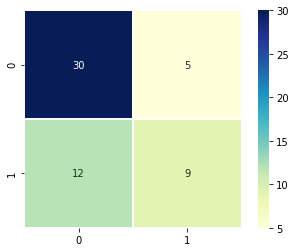

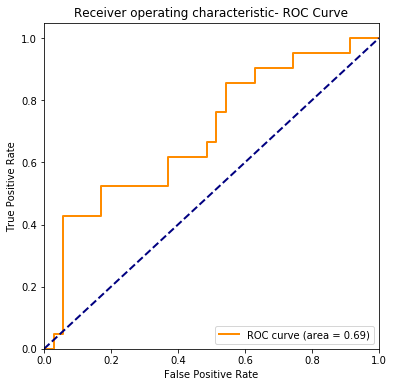

 
After hyperparameter tuning cv = 5: 
Random search optimal values
--------------------------
AdaBoost Training accuracy:  73.4375
--------------------------
AdaBoost Testing accuracy:  62.5
--------------------------
Confusion Matrix
--------------------------


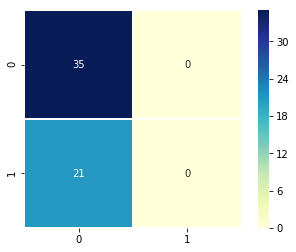

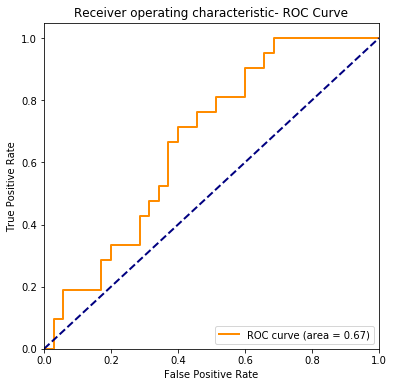

In [224]:
train_report(adb_model,"AdaBoost", xtCV_model, Xtrain, ytrain, Xtest, ytest)

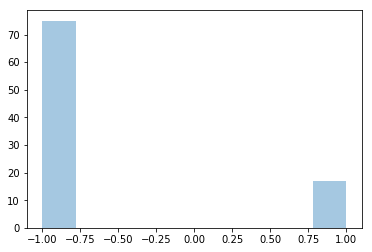

In [225]:
sns.distplot(adb_model.predict(select.transform(xtestprof)),kde=False);

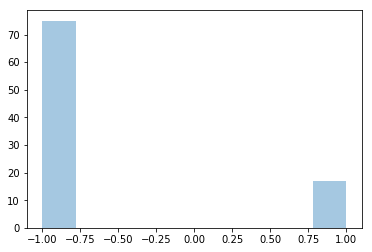

In [226]:
sns.distplot(adbCV_model.best_estimator_.predict(select.transform(xtestprof)),kde=False);